In [40]:
import os
import urllib.request

# URL to download the script from
branch = 'main'  # or whichever branch you want to use
url = f'https://raw.githubusercontent.com/NVIDIA/NeMo/{branch}/scripts/dataset_processing/process_speech_commands_data.py'
file_path = 'process_speech_commands_data.py'

# Check if the file already exists
if not os.path.exists(file_path):
    print(f"{file_path} not found. Downloading from {url}...")
    
    # Use urllib to download the file
    urllib.request.urlretrieve(url, file_path)
    
    print(f"{file_path} downloaded successfully!")
else:
    print(f"{file_path} already exists.")

process_speech_commands_data.py already exists.


In [41]:
import numpy as np
import librosa
import scipy.signal as signal
import os
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import librosa
from keras.models import load_model

In [42]:
# Read file paths and labels from the text file
def read_file_paths_and_labels(file_list_path):
    file_paths = []
    labels = []
    with open(file_list_path, 'r') as file:
        for line in file:
            
            
            line = line.strip() 
            # Remove any leading/trailing whitespace
            if line:
                label, filename = line.split('/', 1)
                
                full_path = os.path.join("C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2", line)
                
                file_paths.append(full_path)
                labels.append(label)
    return file_paths, labels

# Example file list path
file_list_path = 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\testing_list.txt'
file_paths, labels = read_file_paths_and_labels(file_list_path)

# Load and process all audio files
audio_data = {}

In [43]:
import numpy as np
import librosa
import os


def load_audio(file_path, sr=16000):
    # Load the audio file with librosa
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio, sample_rate

def load_all_audios_from_directory(directory, sr=16000):
    audio_data = {}

In [44]:

def normalize_audio(audio):
    return librosa.util.normalize(audio)

def normalize_all_audios(audio_data):
    normalized_audio_data = {}
    
    for file_name, (audio, sample_rate) in audio_data.items():
        normalized_audio = normalize_audio(audio)
        normalized_audio_data[file_name] = (normalized_audio, sample_rate)
    
    return normalized_audio_data



# Now 'normalized_audio_files' contains a dictionary with file names as keys and (normalized_audio, sample_rate) as values


In [45]:
def extract_mfcc(audio, sr, n_mfcc=13, hop_length=512, n_fft=2048):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return mfcc

def extract_mfcc_features(audio_data, **kwargs):
    features = {}
    
    for file_name, (audio, sr) in audio_data.items():
        feature = extract_mfcc(audio, sr, **kwargs)
        features[file_name] = feature
    
    return features

In [46]:
import numpy as np


def pad_or_trim_audio(audio, max_length, sr):
    """
    Pads or trims the audio to ensure it has a fixed length.

    Args:
        audio (numpy array): The audio data.
        max_length (float): Desired length of the audio in seconds.
        sr (int): Sample rate of the audio.

    Returns:
        numpy array: Audio data padded or trimmed to the desired length.
    """
    # Calculate the target length in samples
    target_length = int(max_length * sr)

    # Trim if longer than target length
    if len(audio) > target_length:
        return audio[:target_length]
    # Pad with zeros if shorter than target length
    else:
        return np.pad(audio, (0, target_length - len(audio)))


def pad_or_trim_audios(normalized_audio_files):
    audio_fixed_length = {}
    
    for file_name, (audio, sample_rate) in normalized_audio_files.items():
        audio_length =pad_or_trim_audio(audio, max_length=1.0, sr=sample_rate)
        audio_fixed_length[file_name] =audio_length
    
    return audio_fixed_length


In [47]:
import numpy as np
import scipy.signal as signal  # For Wiener filtering

# Wiener filtering for noise reduction
def reduce_noise_wiener(audio):
    """
    Reduces noise from the audio using Wiener filtering.
    
    Args:
        audio (numpy array): The input audio data.
    
    Returns:
        numpy array: The audio with noise reduced using Wiener filtering.
    """
    # Apply Wiener filter to reduce noise
    reduced_noise_audio = signal.wiener(audio)
    return reduced_noise_audio

In [48]:
import numpy as np
import librosa
import scipy.signal

def noise_reduction(audio, sr, noise_reduction_factor=0.6, frame_length=2048, hop_length=512):
   
    # Perform Short-Time Fourier Transform (STFT)
    stft = librosa.stft(audio, n_fft=frame_length, hop_length=hop_length)
    magnitude, phase = librosa.magphase(stft)

    # Calculate the mean magnitude of the noise
    noise_mean = np.mean(magnitude, axis=1, keepdims=True)
    
    # Create a mask based on the noise mean and reduction factor
    mask = magnitude > (noise_mean * noise_reduction_factor)
    
    # Apply the mask to the magnitude
    magnitude_cleaned = magnitude * mask
    
    # Reconstruct the complex STFT
    stft_cleaned = magnitude_cleaned * phase

    # Perform Inverse Short-Time Fourier Transform (ISTFT)
    cleaned_audio = librosa.istft(stft_cleaned, hop_length=hop_length)

    return cleaned_audio

In [49]:
def bandpass_filter(audio, sr, lowcut=300, highcut=3000):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_audio = signal.filtfilt(b, a, audio)
    return filtered_audio


In [50]:
def fitness_function(audio_file, n_mfcc, hop_length, n_fft):
    audio, sr = load_audio(audio_file)
    if audio is None:  # Skip if loading fails
        return float('inf')
    mfcc = extract_mfcc(audio, sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return np.mean(np.abs(mfcc))  # Simple fitness function based on mean absolute value

class Particle:
    def __init__(self, bounds):
        self.position = np.random.uniform(bounds[:, 0], bounds[:, 1])
        self.velocity = np.random.uniform(-1, 1, bounds.shape[0])
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

def optimize_parameters(file_paths, bounds, num_particles=10, num_iterations=100):
    swarm = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = np.copy(swarm[0].position)
    global_best_score = float('inf')
    
    for _ in range(num_iterations):
        for particle in swarm:
            score = fitness_function(file_paths[0], int(particle.position[0]), int(particle.position[1]), int(particle.position[2]))
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)
                
            if score < global_best_score:
                global_best_score = score
                global_best_position = np.copy(particle.position)
        
        # Update velocities and positions
        for particle in swarm:
            inertia = 0.5 * particle.velocity
            cognitive = np.random.rand() * (particle.best_position - particle.position)
            social = np.random.rand() * (global_best_position - particle.position)
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity
            
            # Ensure the position is within bounds
            particle.position = np.clip(particle.position, bounds[:, 0], bounds[:, 1])
    
    return global_best_position, global_best_score

def apply_energy_threshold(mfcc, threshold=0.1):
    """
    Apply energy thresholding to the MFCC coefficients.
    
    Args:
        mfcc (numpy array): The MFCC coefficients.
        threshold (float): The energy threshold value.
    
    Returns:
        numpy array: The thresholded MFCC coefficients.
    """
    # Set values below the threshold to zero
    mfcc[mfcc < threshold] = 0
    return mfcc

In [51]:
def apply_energy_threshold(mfcc, threshold):
    # Apply energy thresholding to MFCC features
    energy = np.sum(mfcc**2, axis=0)  # Compute the energy of each frame
    mask = energy > threshold  # Create a binary mask where energy is above threshold
    return mfcc[:, mask] 

In [52]:
def plot_mfcc(mfcc, sr):
    """
    Plots the MFCCs as a heatmap.

    Args:
        mfcc (numpy array): The MFCC features.
        sr (int): The sample rate of the audio.
    """
    plt.figure(figsize=(10, 6))
    # Display MFCC as a heatmap
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

In [53]:
# Define parameter bounds for n_mfcc, hop_length, and n_fft
bounds = np.array([[13,40],  # n_mfcc
                   [256, 512],  # hop_length
                   [512, 2048]])  # n_fft

# Run the optimization
best_params, best_score = optimize_parameters(file_paths, bounds)

print(f"Best parameters: n_mfcc={int(best_params[0])}, hop_length={int(best_params[1])}, n_fft={int(best_params[2])}")
print(f"Best score (mean MFCC value): {best_score}")


Best parameters: n_mfcc=40, hop_length=297, n_fft=2048
Best score (mean MFCC value): 18.503019332885742


In [54]:
# Optimize filter parameters


In [55]:
features_list = []
labels_list = []
best_params,best_lowcut =optimize_parameters(file_paths, bounds)
best_highcut=600
print(f"Optimal lowcut: {best_lowcut}, Optimal highcut: {best_highcut}")
best_threshold = 0.6


for file_path, label in zip(file_paths, labels):
    print(f"Processing: {file_path}")

    # Load the audio file
    audio, sr = load_audio(file_path)
    
    # Reduce noise using Wiener filtering
    denoised_audio = noise_reduction(audio,sr)


    # Apply bandpass filter with optimized parameters
    filtered_audio = bandpass_filter(denoised_audio, sr, best_lowcut, best_highcut)

    # Normalize the audio
    normalized_audio = normalize_audio(filtered_audio)

    # Pad or trim the audio to a fixed length of 1.0 second
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)

    # Extract MFCC features
    mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=int(best_params[0]), hop_length=int(best_params[1]), n_fft=int(best_params[2]))

    # Apply energy thresholding with the optimized threshold
    thresholded_mfcc = apply_energy_threshold(mfcc_features, best_threshold)

    # Append the thresholded MFCC features to the features list
    features_list.append( thresholded_mfcc)

    # Append the corresponding label to the labels list
    labels_list.append(label)

    

# Summary of extracted features
print(f"Extracted features for {len(features_list)} audio files.")

Optimal lowcut: 18.511524200439453, Optimal highcut: 600
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bb05582b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/97f4c236_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f2e59fea_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fdb5155e_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/dc75148d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3f170018_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/18f8afd5_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5c8af87a_no

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/2d82a556_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a80f9f53_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cfbedff9_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/18f8afd5_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1f653d27_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cfbedff9_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c9b5ff26_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3efef882_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b11a05d2_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5744b6a7_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/beb458a4_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/0ea0e2f4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/91b03183_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1acc97de_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3b4f8f24_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/26b28ea7_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/893705bb_nohash_7.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/37dca74f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fb7eb481_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cfde27ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/daf230ac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/964e8cfd_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a6f2fd71_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a6f2fd71_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/7add4c5f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fb7eb481_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c22d3f18_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8769c34c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8fe67225_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/189cbabe_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/4c7c95de_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/95ba4996_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b97c9f77_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f9643d42_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/0cb74144_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/18f8afd5_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/7257420c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/e1469561_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/5c8af87a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/aa48c94a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/837a0f64_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/e49428d9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9d4bab4f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9d4bab4f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/aa80f517_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/893705bb_nohash_13.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c9b5ff26_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/2d82a556_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cfbedff9_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f2e59fea_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1f653d27_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9dc1889e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/2796ac50_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\d

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d962e5ac_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a591c2ea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/87070229_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/135c6841_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d103dd6e_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c7dc7278_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c7dc7278_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d103dd6e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cd85758f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/5170b77f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ca4d5368_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/db24628d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_8.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/370844f7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9a69672b_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b49caed3_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/893705bb_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/94de6a6a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b83c1acf_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/6021f08b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b737ee80_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ad6a46f1_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/dcb57584_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f9643d42_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/3df9a3d4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1b4c9b89_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f292725f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/475b61f1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8fe67225_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/0c40e715_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8769c34c_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/aef8dcf5_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/24ad3ebe_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/aa48c94a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\goo

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/0ea0e2f4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/1acc97de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/a9f54d8d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/5744b6a7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/b11a05d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/8625475c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/964e8cfd_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/d9e9f554_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/50033893_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/f9643d42_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/81dc4a94_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/d5b963aa_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/a2473d62_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/f17d21b5_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/2005ca25_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/b83c1acf_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/1f3bece8_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/82b99576_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/c0e0f834_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/80c45ed6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/d5ca80c6_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/40c4e774_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/2796ac50_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/4fd1443e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/b2e2773a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/f6af2457_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/27c30960_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/daf230ac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/daf230ac_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/7add4c5f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/412c675c_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/798f702a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/653a48f5_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/422d3197_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/422d3197_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/7add4c5f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/bb05582b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/bb05582b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/837a0f64_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_1.wav
Processing: C:\User

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/db24628d_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/5170b77f_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/a6f2fd71_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/5170b77f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/db24628d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/3b4f8f24_nohash_4.wav
Processing: C:\User

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bb05582b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/cfbedff9_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/d1bf406b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/3659fc1c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/beb458a4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/db24628d_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/5170b77f_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/a6f2fd71_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/fb7eb481_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/5170b77f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/ca4d5368_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/db24628d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5b1db3ee_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/7257420c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5c8af87a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/aa48c94a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d1bf406b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c7124b73_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c7124b73_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/9d4bab4f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/837a0f64_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d7467392_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/6e916de8_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/7e1054e7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d103dd6e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/105a0eea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/6b889021_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/0ea0e2f4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/863880b7_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/863880b7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/3df9a3d4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/a7216980_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/189cbabe_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cc592808_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/6205088b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/4c7c95de_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/f9643d42_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d5b963aa_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/a2473d62_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3efef882_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/692a88e6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/2d82a556_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/1f653d27_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/aa80f517_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/553f1a79_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/c0e0f834_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/c0e0f834_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/553f1a79_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/893705bb_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/af8b2f2c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/af8b2f2c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/653a48f5_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/893705bb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b1f8326d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b49caed3_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/cd85758f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/412c675c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/ea356919_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/5525ff66_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/d0faf7e4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8494fba8_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/0cb74144_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/9b3ea809_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/475b61f1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/0c40e715_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bb05582b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e41a903b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5ff3f9a1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0bac8a71_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/692a88e6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/553f1a79_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/aa80f517_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c9b5ff26_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/2d82a556_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a80f9f53_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/4c6167ca_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c7dc7278_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/964e8cfd_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5e3dde6b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/beb458a4_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9a69672b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0ea0e2f4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/91b03183_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1acc97de_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca4d5368_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/db24628d_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5170b77f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cd85758f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/412c675c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/37dca74f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/fb7eb481_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/daf230ac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/964e8cfd_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8056e897_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/f9643d42_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/3df9a3d4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1b4c9b89_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a7216980_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9d171fee_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c22d3f18_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8769c34c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8fe67225_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/5c8af87a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/aa48c94a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/e49428d9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/28497c5b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/9d4bab4f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/c7124b73_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/c7124b73_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/9d4bab4f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/837a0f64_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/a591c2ea_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/0d53e045_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/283d7a53_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/283d7a53_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/0d53e045_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/85834399_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/a591c2ea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/4c6167ca_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/48a8a69d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/587f3271_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/fe1916ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/ca48dc76_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/7add4c5f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/f5496439_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/83957201_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/caedb73a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/94de6a6a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/8a325749_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/68dd409e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/82d0d3ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/af405b69_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/563aa4e6_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/97f4c236_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f428ca69_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/bb05582b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/af130f12_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c518d1b1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/aa80f517_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/692a88e6_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/67961766_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c0e0f834_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e41a903b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3d86b69a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/837a0f64_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3d86b69a_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e41a903b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/ca4d5368_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5e3dde6b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/beb458a4_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a69672b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/0ea0e2f4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/91b03183_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1acc97de_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3b4f8f24_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_7.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/beb458a4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/798f702a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b49caed3_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1acc97de_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/fa446c16_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/422d3197_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/422d3197_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b83c1acf_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/2fa39636_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/47d01978_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/bfd26d6b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e0c782d5_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/63f7a489_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d0faf7e4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a2473d62_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d5b963aa_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/563aa4e6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/97f4c236_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/c518d1b1_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/ffb86d3c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/4a0e2c16_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/3d86b69a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/e41a903b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/692a88e6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2d82a556_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/7add4c5f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/fb7eb481_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/5170b77f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/db24628d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/370844f7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/d1a4fb3f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/893705bb_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/422d3197_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/af8b2f2c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/cc592808_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a4e8a997_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/4f8ef132_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/9b3ea809_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8494fba8_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/85d2ac4b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/f264e0df_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2fa39636_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2005ca25_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/87070229_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/87070229_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/ca4d5368_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/beb458a4_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/91b03183_nohash_3.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/b7e9f841_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/bfd26d6b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/e0c782d5_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/63f7a489_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/d5b963aa_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/0cb74144_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/f9643d42_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/189cbabe_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8fe67225_nohash_0.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/837a0f64_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d91a159e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6f689791_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5c8af87a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e1469561_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/18f8afd5_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe52b97_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f2e59fea_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/563aa4e6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/37fc5d97_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/220ee1ef_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4fd1443e_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b2e2773a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ef2a3cfb_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c7dc7278_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1cb788bc_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/48a8a69d_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4c6167ca_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3b4f8f24_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/2c6d3924_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/91b03183_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1acc97de_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a69672b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/bed06fac_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/beb458a4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5e3dde6b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5170b77f_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d0faf7e4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/83957201_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5eb5fc74_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/caedb73a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/94de6a6a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/94de6a6a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e0c782d5_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5eb5fc74_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/83957201_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a60a09cf_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c9e251d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c22d3f18_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe67225_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/189cbabe_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a4e8a997_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a7c1f83_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1b4c9b89_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4f8ef132_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f0ae7203_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/837a0f64_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e49428d9_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/837a0f64_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d91a159e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8c7f81df_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/692a88e6_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/6f689791_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5c8af87a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4c6167ca_nohash_6.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4c841771_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c7dc7278_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4fd1443e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b2e2773a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ef2a3cfb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4fd1443e_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/43fc47a7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4845bb10_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1acc97de_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/0487ba9b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b49caed3_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/91b03183_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3b4f8f24_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/26b28ea7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3b4f8f24_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/37dca74f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cd85758f_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fb7eb481_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a6f2fd71_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a7216980_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c22d3f18_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9d171fee_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f5496439_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1b4c9b89_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8fe67225_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/af7a8296_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8769c34c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8769c34c_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a60a09cf_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c22d3f18_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8fe67225_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f292725f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/189cbabe_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_17.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/6f689791_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/692a88e6_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e41a903b_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f0ae7203_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/837a0f64_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/837a0f64_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d91a159e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/6f689791_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\googl

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4290ca61_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/87070229_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4c6167ca_nohash_6.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/43fc47a7_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/37fc5d97_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4fd1443e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b2e2773a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ef2a3cfb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4fd1443e_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/3659fc1c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b49caed3_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/91b03183_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/3b4f8f24_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8c0e5970_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/44715c1c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/26b28ea7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8c0e5970_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/7add4c5f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a6f2fd71_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a7216980_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c22d3f18_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9d171fee_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f5496439_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1b4c9b89_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a7c1f83_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a4383927_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f297e878_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8769c34c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8769c34c_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f297e878_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c9e251d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0c40e715_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c22d3f18_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8fe67225_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f292725f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/97f4c236_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/62ff07ef_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f428ca69_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/bb05582b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/c518d1b1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/bb05582b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/62ff07ef_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/97f4c236_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/563aa4e6_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3d86b69a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/837a0f64_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e49428d9_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e41a903b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ea37ca08_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/67961766_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/c0e0f834_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fce96bac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/80c45ed6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/863880b7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3b4f8f24_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/1acc97de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/91b03183_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9a69672b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/beb458a4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5e3dde6b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/37dca74f_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b11a05d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/587f3271_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fa446c16_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/893705bb_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/893705bb_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/587f3271_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b49caed3_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fe1916ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/798f702a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ca48dc76_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a2473d62_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d5b963aa_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/0cb74144_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f9643d42_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/95ba4996_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b97c9f77_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4f8ef132_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c7c95de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/6205088b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/f0ae7203_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/881583a6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/881583a6_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/f0ae7203_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/d91a159e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8c7f81df_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/6f689791_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/aa48c94a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5b1db3ee_nohash_1.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/0ea0e2f4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/1acc97de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/a9f54d8d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/0ea0e2f4_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/50033893_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/beb458a4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8625475c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/964e8cfd_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/022cd682_nohash_0.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/b97c9f77_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4c7c95de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/6205088b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8fe67225_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af7a8296_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/f297e878_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8769c34c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/a4e8a997_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4f8ef132_nohash_0.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c518d1b1_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/97f4c236_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9dc1889e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4a0e2c16_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cfbedff9_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c9b5ff26_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e71b4ce6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/692a88e6_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/aa80f517_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0d53e045_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/283d7a53_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a591c2ea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/87070229_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c6167ca_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5f01c798_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/03401e93_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/210f3aa9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c7dc7278_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cd85758f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5170b77f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ca4d5368_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/db24628d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c6167ca_nohash_8.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d1a4fb3f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b49caed3_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b1f8326d_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/893705bb_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/94de6a6a_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/94de6a6a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/dfdabe19_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/2aa787cf_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b83c1acf_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/6021f08b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d5b963aa_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/dcb57584_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f9643d42_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d5b963aa_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9b3ea809_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f9643d42_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b97c9f77_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cc592808_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/189cbabe_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8fe67225_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0c40e715_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8769c34c_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/7e1054e7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/caf9fceb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/105a0eea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8625475c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5744b6a7_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5744b6a7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/b11a05d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8625475c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/964e8cfd_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/2005ca25_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/2fa39636_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/b83c1acf_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/1f3bece8_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/82b99576_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/e5e54cee_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/bfd26d6b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/63f7a489_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/b97c9f77_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d91a159e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5c8af87a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e1469561_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/44260689_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/18f8afd5_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/84d1e469_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fdb5155e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f2e59fea_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e9901cf0_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4c6167ca_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/42beb5eb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/220ee1ef_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4fd1443e_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c7dc7278_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/03401e93_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9a356ab9_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/48a8a69d_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4c6167ca_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/3b4f8f24_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/91b03183_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1acc97de_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9a69672b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/bed06fac_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/beb458a4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5e3dde6b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/022cd682_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/db24628d_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d0faf7e4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/aa233654_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2aa787cf_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0fa1e7a9_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/caedb73a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/94de6a6a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/94de6a6a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/caedb73a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0fa1e7a9_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c9e251d2_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/8769c34c_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a60a09cf_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c9e251d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0c40e715_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c22d3f18_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/8fe67225_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f292725f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/189cbabe_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e41a903b_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e49428d9_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/837a0f64_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/3d86b69a_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/881583a6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e49428d9_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d91a159e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8c7f81df_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5c8af87a_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4290ca61_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/87070229_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4c841771_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b2e2773a_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4fd1443e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b2e2773a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ef2a3cfb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4fd1443e_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/37fc5d97_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/cd85758f_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/022cd682_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5e3dde6b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/beb458a4_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/bed06fac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d9e9f554_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a69672b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/50033893_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1acc97de_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f5496439_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1b4c9b89_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a7c1f83_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4620dc14_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d0faf7e4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/83957201_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/caedb73a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/94de6a6a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8a325749_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8fe67225_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/475b61f1_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/189cbabe_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a4e8a997_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a7c1f83_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1b4c9b89_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4f8ef132_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b97c9f77_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f9643d42_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/82d0d3ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/563aa4e6_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c518d1b1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e41a903b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/67961766_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/aa80f517_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/692a88e6_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/553f1a79_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9e2ce5e3_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/893705bb_nohash_10.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c9b5ff26_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cfbedff9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8625475c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/964e8cfd_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5e3dde6b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/beb458a4_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a69672b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/50033893_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/91b03183_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/1acc97de_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/3b4f8f24_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a6f2fd71_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/7dc95912_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cd85758f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/37dca74f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/db24628d_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ca4d5368_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5170b77f_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/beb458a4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/798f702a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2fa39636_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bfd26d6b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ea356919_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/63f7a489_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d0faf7e4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d5b963aa_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0cb74144_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f9643d42_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3d86b69a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3d86b69a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/aa80f517_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/c9b5ff26_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/cfbedff9_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/f2e59fea_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/cfbedff9_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/c9b5ff26_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/aa80f517_nohash_0.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/fb7eb481_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/db24628d_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/ca4d5368_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/5170b77f_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/893705bb_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/893705bb_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/5170b77f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/db24628d_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/ca4d5368_nohash_1.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8fe52b97_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/24ad3ebe_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6f689791_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8c7f81df_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/f0ae7203_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/881583a6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/881583a6_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8c7f81df_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6f689791_nohash_0.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5744b6a7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/b11a05d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8625475c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8625475c_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/964e8cfd_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/0b57a6ed_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6b889021_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/022cd682_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5e3dde6b_nohash_0.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/81dc4a94_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8fe67225_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/af7a8296_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/f297e878_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8769c34c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/f297e878_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/a60a09cf_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/c9e251d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/f292725f_nohash_0.wav
Processing: C:\Users\naikg\keyword-sp

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f2e59fea_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e9901cf0_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/af405b69_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/563aa4e6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/97f4c236_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/62ff07ef_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bb05582b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/97f4c236_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/563aa4e6_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/42beb5eb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/220ee1ef_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/4fd1443e_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b2e2773a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/105a0eea_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/210f3aa9_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c7dc7278_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1cb788bc_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/4c6167ca_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3b4f8f24_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/893705bb_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/44715c1c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/26b28ea7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/893705bb_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3b4f8f24_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/91b03183_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/0487ba9b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1acc97de_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9a7c1f83_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d0faf7e4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/0cb74144_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/94de6a6a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8a325749_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8a325749_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/94de6a6a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e0c782d5_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8056e897_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8fe67225_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f292725f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/189cbabe_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a4e8a997_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1b4c9b89_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b97c9f77_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f9643d42_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d5b963aa_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9b3ea809_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/80c45ed6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/c9b5ff26_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/cfbedff9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/1f653d27_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/40c4e774_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/2796ac50_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4fd1443e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0f250098_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0f250098_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/ca48dc76_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/bb31b82b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/7add4c5f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/f5496439_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/9a7c1f83_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4620dc14_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/a4383927_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/aa233654_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/94de6a6a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e49428d9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c7124b73_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c7124b73_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9d4bab4f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/837a0f64_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e49428d9_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5c8af87a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e1469561_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/7257420c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f2e59fea_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9dc1889e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/cfbedff9_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d5ca80c6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c9b5ff26_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e1469561_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9e2ce5e3_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/aa80f517_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/553f1a79_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d103dd6e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5f814c23_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c6167ca_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/87070229_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/87070229_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/7e1054e7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c6167ca_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d103dd6e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c7dc7278_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8ea6dec6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/ca4d5368_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/db24628d_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5170b77f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/cd85758f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/412c675c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/37dca74f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/fb7eb481_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/cfde27ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8fe67225_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/189cbabe_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/95ba4996_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/b97c9f77_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f9643d42_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0cb74144_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d5b963aa_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d0faf7e4_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/63f7a489_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aa80f517_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5c8af87a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/24ad3ebe_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e1469561_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/7257420c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/18f8afd5_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f2e59fea_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/68dd409e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/82d0d3ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e49428d9_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e41a903b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fce96bac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/80c45ed6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aa80f517_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/692a88e6_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5c8af87a_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9e2ce5e3_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5e3dde6b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/37dca74f_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b11a05d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a6f2fd71_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8625475c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_6.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/beb458a4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/798f702a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b49caed3_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fa446c16_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/893705bb_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/893705bb_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b49caed3_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fe1916ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca48dc76_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/0cb74144_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/81dc4a94_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f9643d42_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/95ba4996_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b97c9f77_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/4c7c95de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f292725f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/6205088b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/189cbabe_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bb05582b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/97f4c236_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/563aa4e6_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/af405b69_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fdb5155e_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/adebe223_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f2e59fea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/84d1e469_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/18f8afd5_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4c6167ca_nohash_7.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4290ca61_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f6af2457_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d962e5ac_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/27c30960_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d962e5ac_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4290ca61_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/87070229_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4c6167ca_nohash_6.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a6f2fd71_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6f2f57c1_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/964e8cfd_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6f2f57c1_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cd85758f_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/022cd682_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5e3dde6b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/beb458a4_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bed06fac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fb7eb481_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a6f2fd71_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a7216980_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c22d3f18_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9d171fee_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f5496439_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1b4c9b89_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9a7c1f83_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d0faf7e4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/63f7a489_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d0faf7e4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d5b963aa_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/0cb74144_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/81dc4a94_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f9643d42_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b97c9f77_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6205088b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/189cbabe_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/82d0d3ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/563aa4e6_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/97f4c236_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f428ca69_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bb05582b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c518d1b1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bb05582b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/62ff07ef_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/97f4c236_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/692a88e6_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_10.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c9b5ff26_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/cfbedff9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4fd1443e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c841771_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/a8e25ebb_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d962e5ac_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d9e9f554_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/beb458a4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5e3dde6b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b11a05d2_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/ca4d5368_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/964e8cfd_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8625475c_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/964e8cfd_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0b57a6ed_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b49caed3_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/fe1916ba_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5170b77f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/db24628d_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bb31b82b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/ca4d5368_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/37dca74f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/cd85758f_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/fb7eb481_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d0faf7e4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d5b963aa_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0cb74144_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/81dc4a94_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f9643d42_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b97c9f77_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4f8ef132_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9a7c1f83_nohash_6.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c7c95de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognitio

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f428ca69_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/bb05582b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c518d1b1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/bb05582b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/97f4c236_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/563aa4e6_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/af405b69_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/adebe223_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f2e59fea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/aa80f517_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/692a88e6_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5c8af87a_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c9b5ff26_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cfbedff9_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4a0e2c16_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4fd1443e_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c841771_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4290ca61_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/893705bb_nohash_7.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/893705bb_nohash_6.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/863880b7_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/44715c1c_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/3b4f8f24_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1acc97de_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/91b03183_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a69672b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/beb458a4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/daf230ac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964e8cfd_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a6f2fd71_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a6f2fd71_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7add4c5f_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7dc95912_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/fb7eb481_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cd85758f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/37dca74f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d5b963aa_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/83957201_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/dcb57584_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f9643d42_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7bae88ed_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a7c1f83_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1b4c9b89_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/189cbabe_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a7216980_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/95ba4996_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a7c1f83_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a4e8a997_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/189cbabe_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8fe67225_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8769c34c_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/bb05582b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f2e59fea_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/c9b5ff26_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\da

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/91b03183_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/3b4f8f24_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/893705bb_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/893705bb_nohash_5.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/3b4f8f24_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/91b03183_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/beb458a4_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/a6f2fd71_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/fb7eb481_nohash_0.wav
Processing: C:\Users\naikg\k

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/0cb74144_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d5b963aa_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f9643d42_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/189cbabe_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/8fe67225_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/bb05582b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/97f4c236_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/563aa4e6_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f428ca69_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e41a903b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3d86b69a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/840c366d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3d86b69a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e41a903b_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5ff3f9a1_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3efef882_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/692a88e6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/aa80f517_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c7dc7278_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c7dc7278_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4c6167ca_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/87070229_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d7467392_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d7467392_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0d53e045_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/87070229_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/caf9fceb_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/37dca74f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fb7eb481_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/ffa76c4a_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/daf230ac_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/964e8cfd_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a6f2fd71_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a6f2fd71_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fb7eb481_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/cd85758f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c22d3f18_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0c40e715_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f297e878_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a7216980_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/8769c34c_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/8fe67225_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/189cbabe_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/6205088b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/95ba4996_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_r

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/8769c34c_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bb05582b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/97f4c236_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/563aa4e6_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f2e59fea_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/fdb5155e_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aef8dcf5_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/dc75148d_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c9b5ff26_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d5ca80c6_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c9b5ff26_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e1469561_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9e2ce5e3_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aa80f517_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/692a88e6_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/fce96bac_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c0e0f834_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e41a903b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c7dc7278_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4fd1443e_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/105a0eea_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/964e8cfd_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5e3dde6b_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/beb458a4_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9a69672b_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0ea0e2f4_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/91b03183_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/cd85758f_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/37dca74f_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bb31b82b_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/db24628d_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/ca4d5368_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5170b77f_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/beb458a4_nohash_4.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/ca48dc76_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/798f702a_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/189cbabe_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/95ba4996_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b97c9f77_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f9643d42_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0cb74144_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d5b963aa_nohash_0.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d0faf7e4_nohash_2.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/63f7a489_nohash_1.wav
Processing: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e0c782d5_nohash_3.wav
Processing: C:\Users\naikg\keyword-spotting\data\google

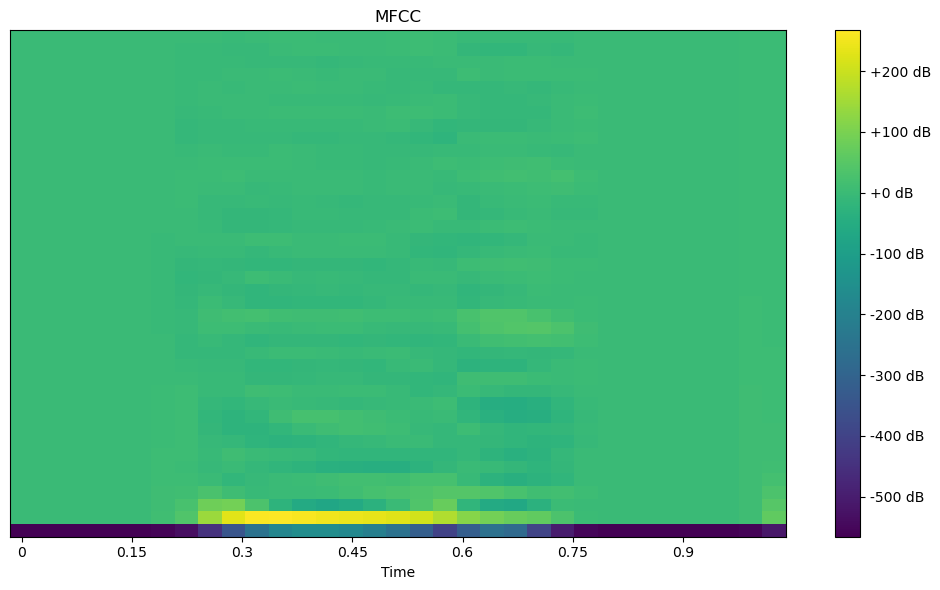

In [56]:
plot_mfcc(features_list[0],sr)

In [57]:
from sklearn.model_selection import train_test_split

def split_data(files, labels, test_size=0.2, val_size=0.2):
    # Split data into training and temp (for validation and test)
    X_train, X_temp, y_train, y_temp = train_test_split(files, labels, test_size=test_size + val_size, random_state=42)
    
    # Split temp data into validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
file_paths=[]
labels=[]
# Example usage



X_train, X_val, X_test, y_train, y_val, y_test = split_data(features_list, labels_list)

# Print the results
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 6603
Validation set size: 2201
Test set size: 2201


In [58]:
import numpy as np

# Function to pad a 2D array (each sub-array)
def pad_array_2d(arr, target_shape):
    padded_arr = np.zeros(target_shape)  # Create an array filled with zeros
    arr = np.array(arr)
    # Copy the content of the original array into the padded array
    padded_arr[:arr.shape[0], :arr.shape[1]] = arr
    return padded_arr

# Find the maximum number of rows and columns
max_rows = max(len(sub_list) for sub_list in features_list)
max_cols = max(len(sub_sub_list) for sub_list in features_list for sub_sub_list in sub_list)

# Pad each sub-array to the maximum rows and columns
features_array = np.array([pad_array_2d(sub_list, (max_rows, max_cols)) for sub_list in features_list])
labels_array = np.array(labels_list)

# Save arrays to .npy files
np.save('train_features_1.npy', features_array)
np.save('train_labels_1.npy', labels_array)

print("Data padded and saved successfully.")

Data padded and saved successfully.


In [67]:
import numpy as np

# Load the saved .npy files
features_array = np.load('train_features_1.npy', allow_pickle=True)
labels_array = np.load('train_labels_1.npy', allow_pickle=True)

print("Data loaded successfully.")

Data loaded successfully.


In [110]:
import numpy as np

# Load the saved .npy files
features_array = np.load('train_features.npy', allow_pickle=True)
labels_array = np.load('train_labels.npy', allow_pickle=True)

print("Data loaded successfully.")

Data loaded successfully.


In [111]:
set(labels_array)

{'backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero'}

In [112]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [113]:
# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,)

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()


# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Reshape if necessary
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Ensure it's 3D
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))  

X_train shape: (8804, 40, 36)
y_train shape: (8804, 35)


In [114]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

print("Training and validation data split successfully.")
print(f"X_train set size: {X_train.shape}")
print(f"X_val set size: {X_test.shape}")
print(f"y_train set size: {y_train.shape}")
print(f"y_val set size: {y_test.shape}")

Training and validation data split successfully.
X_train set size: (8804, 40, 36)
X_val set size: (2201, 40, 36)
y_train set size: (8804, 35)
y_val set size: (2201, 35)


In [115]:
import tensorflow as tf
from tensorflow.keras import layers

class AttentionLayer(layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.query_dense = layers.Dense(units)
        self.key_dense = layers.Dense(units)
        self.value_dense = layers.Dense(units)
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs, mask=None):
        """
        Forward pass for the attention layer.
        Args:
        inputs: Tensor of shape (batch_size, seq_length, feature_dim).
        mask: Optional tensor for masking padded positions (batch_size, seq_length).
        
        Returns:
        Tensor of shape (batch_size, seq_length, units), the context vector.
        """
        # Compute query, key, and value projections
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Compute attention scores
        score = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(tf.shape(key)[-1], tf.float32))
        
        if mask is not None:
            score += (mask * -1e9)  # Mask out padding tokens

        # Normalize scores
        attention_weights = self.softmax(score)

        # Compute context vector
        context_vector = tf.matmul(attention_weights, value)
        return context_vector

In [116]:
class AttentionLayer(layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.attention = layers.Dense(self.units, activation='tanh')
        self.attention_weight = layers.Dense(1, activation='softmax')

    def call(self, inputs):
        attention_score = self.attention(inputs)
        attention_weights = self.attention_weight(attention_score)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

def create_bilstm_attention_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # First BiLSTM layer with dropout and batch normalization
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Second BiLSTM layer with dropout and batch normalization
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Apply the attention mechanism
    x = AttentionLayer()(x)

    # Flatten the context vector for the Dense layer
    x = layers.Flatten()(x)

    # Fully connected layers with dropout and batch normalization
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Increase dropout rate
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [123]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

def create_bilstm_attention_model(input_shape, num_classes, 
                                  lstm_units=[64], 
                                  dense_units=64, 
                                  attention_units=16,  # New parameter for AttentionLayer
                                  dropout_rate=0.4, 
                                  l2_reg=0.01):
    inputs = layers.Input(shape=input_shape)

    x = inputs
    for units in lstm_units:
        x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, 
                                             kernel_regularizer=regularizers.l2(l2_reg)))(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.BatchNormalization()(x)

    # Apply the attention mechanism
#     x = AttentionLayer(units=attention_units)(x)
    x = layers.Attention()([x, x]) 

    # Global pooling instead of Flatten for reduced overfitting
    x = layers.GlobalAveragePooling1D()(x)

    # Fully connected layer with L2 regularization, dropout, and batch normalization
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate + 0.3)(x)  # Slightly higher dropout for Dense layers
    x = layers.BatchNormalization()(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
   
    return model


Epoch 1/75
69/69 [==============================] - 25s 278ms/step - loss: 5.8694 - accuracy: 0.0344 - val_loss: 5.1524 - val_accuracy: 0.0373 - lr: 0.0010
Epoch 2/75
69/69 [==============================] - 19s 271ms/step - loss: 5.2211 - accuracy: 0.0416 - val_loss: 4.7421 - val_accuracy: 0.0473 - lr: 0.0010
Epoch 3/75
69/69 [==============================] - 18s 259ms/step - loss: 4.7781 - accuracy: 0.0459 - val_loss: 4.4303 - val_accuracy: 0.0491 - lr: 0.0010
Epoch 4/75
69/69 [==============================] - 18s 266ms/step - loss: 4.4443 - accuracy: 0.0536 - val_loss: 4.1925 - val_accuracy: 0.0591 - lr: 0.0010
Epoch 5/75
69/69 [==============================] - 18s 267ms/step - loss: 4.1839 - accuracy: 0.0580 - val_loss: 4.0052 - val_accuracy: 0.0568 - lr: 0.0010
Epoch 6/75
69/69 [==============================] - 18s 257ms/step - loss: 3.9913 - accuracy: 0.0695 - val_loss: 3.8549 - val_accuracy: 0.0672 - lr: 0.0010
Epoch 7/75
69/69 [==============================] - 21s 298ms/st

Epoch 53/75
69/69 [==============================] - 20s 289ms/step - loss: 2.4854 - accuracy: 0.2798 - val_loss: 2.9576 - val_accuracy: 0.2049 - lr: 4.9000e-04
Epoch 54/75
69/69 [==============================] - 18s 266ms/step - loss: 2.4824 - accuracy: 0.2775 - val_loss: 2.8810 - val_accuracy: 0.2067 - lr: 4.9000e-04
Epoch 55/75
69/69 [==============================] - 19s 274ms/step - loss: 2.4657 - accuracy: 0.2754 - val_loss: 2.9430 - val_accuracy: 0.2194 - lr: 4.9000e-04
Epoch 56/75
69/69 [==============================] - 19s 281ms/step - loss: 2.4523 - accuracy: 0.2804 - val_loss: 2.8929 - val_accuracy: 0.2104 - lr: 4.9000e-04
Epoch 57/75
69/69 [==============================] - 18s 265ms/step - loss: 2.4178 - accuracy: 0.2902 - val_loss: 2.8848 - val_accuracy: 0.2131 - lr: 3.4300e-04
Epoch 58/75
69/69 [==============================] - 18s 266ms/step - loss: 2.3688 - accuracy: 0.3026 - val_loss: 2.8711 - val_accuracy: 0.2226 - lr: 3.4300e-04
Epoch 59/75
69/69 [===============

C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 4s 37ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        32
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        26
           4       0.14      0.05      0.07        42
           5       0.19      0.24      0.21        84
           6       0.33      0.31      0.32       101
           7       0.13      0.24      0.17        91
           8       0.38      0.16      0.23        31
           9       0.25      0.20      0.22        25
          10       0.08      0.07      0.08        94
          11       0.11      0.09      0.10        76
          12       0.33      0.09      0.14        44
          13       0.33      0.07      0.11        29
          14       0.00      0.00      0.00        36
          15       0.25      0.19      0.21        86
    

C:\Users\naikg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\naikg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\naikg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


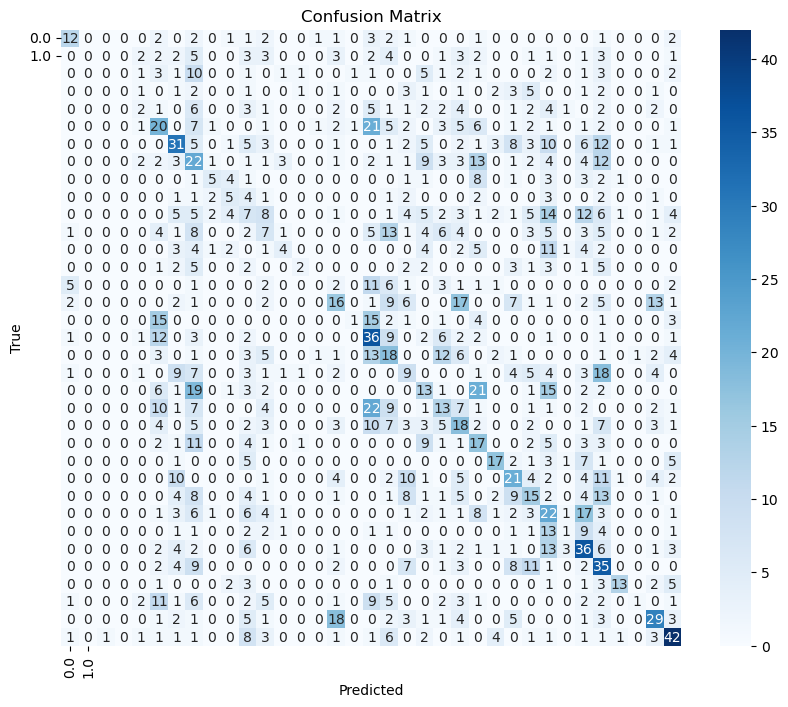

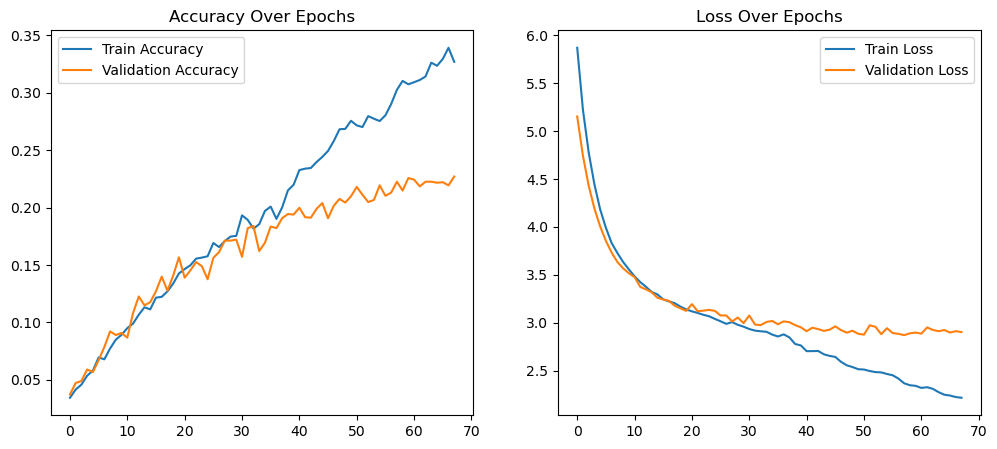

In [124]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import regularizers
# Model parameters
input_shape = (X_train.shape[1], X_train.shape[2])  # Example: (13, 32)
num_classes = y_encoded.shape[1]  # Adjusted to the number of classes in your dataset
model = create_bilstm_attention_model(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set callbacks for early stopping and learning rate reduction
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Fit the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=75,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping, tensorboard]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
model.save('keyword_recognition_model.h5')
# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)
class_names = np.unique(y_train) 

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

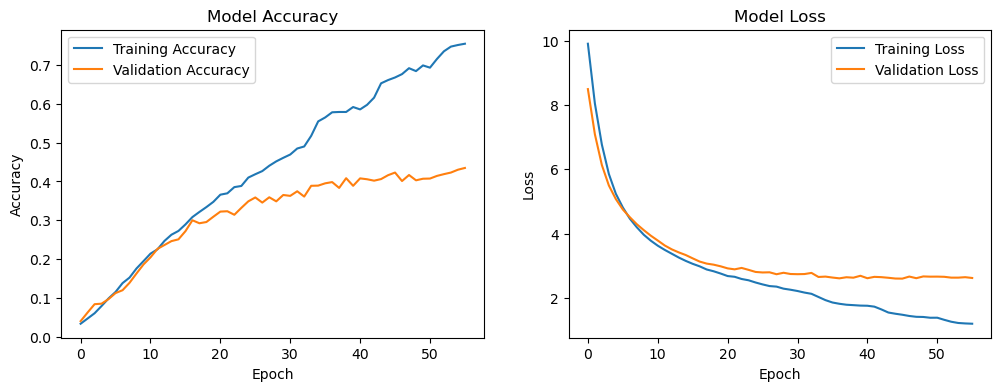

In [109]:
import matplotlib.pyplot as plt

# Assuming 'history' is the returned object from model.fit()
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

# Call the function after training
plot_training_history(history)


69/69 [==============================] - 3s 24ms/step


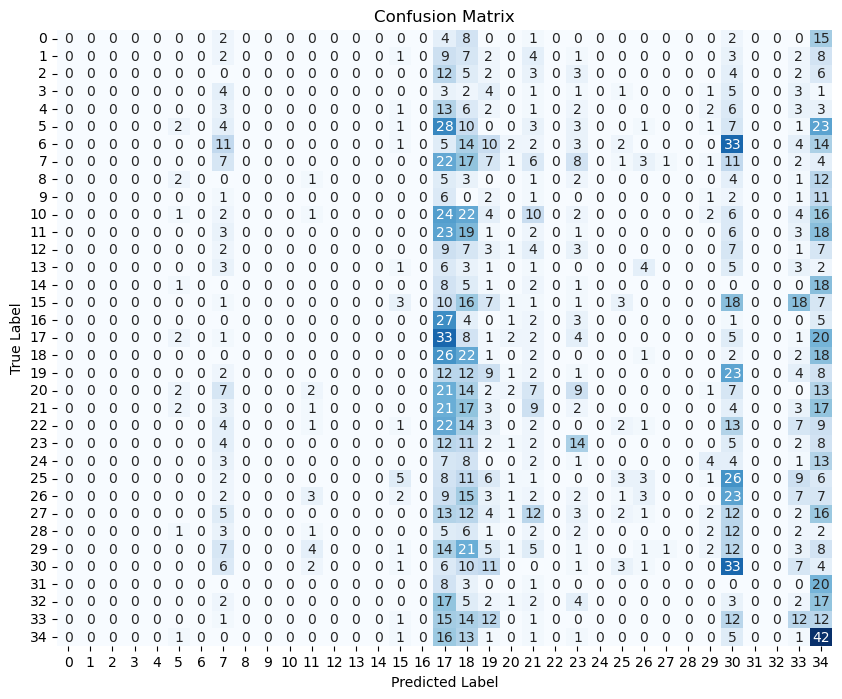

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Step 1: Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
keywords = labels_array

In [ ]:
model = load_model("keyword_recognition_model.h5")

In [ ]:
# Preprocessing functions (similar to earlier)
def preprocess_audio(audio_path, sr=16000, window_size=0.5, stride=0.1):
    """Preprocess the audio file."""
    y, _ = librosa.load(audio_path, sr=sr)

    # Apply noise reduction, bandpass filter, and normalization
    y = noise_reduction(y)  # Placeholder for your noise reduction function
    y = bandpass_filter(y, lowcut, highcut, sr)  # Replace with your filter
    y = normalize_audio(y)  # Placeholder for normalization function

    # Pad or trim the audio to a fixed length
    max_length = sr * 60  # Example: max length of 60 seconds
    y = librosa.util.fix_length(y, max_length)

    # Extract overlapping segments
    step = int(sr * stride)
    segment_length = int(sr * window_size)
    segments = [y[i : i + segment_length] for i in range(0, len(y) - segment_length + 1, step)]

    return segments

def extract_mfcc(segment, sr=16000, n_mfcc=40):
    """Extract MFCC features from a segment."""
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Shape: (frames, n_mfcc)

# Multi-keyword detection
def detect_keywords(audio_path, model, sr=16000, window_size=0.5, stride=0.1, threshold=0.5):
    """
    Detect occurrences of multiple keywords in an audio file.
    """
    segments = preprocess_audio(audio_path, sr, window_size, stride)
    keyword_counts = {keyword: 0 for keyword in keywords}

    for segment in segments:
        # Extract MFCC features
        mfcc_features = extract_mfcc(segment, sr)
        mfcc_features = np.expand_dims(mfcc_features, axis=0)  # Add batch dimension

        # Predict using the model
        predictions = model.predict(mfcc_features)  # Output: probabilities for all keywords
        predicted_label = np.argmax(predictions[0])  # Get the keyword index
        confidence = predictions[0][predicted_label]

        if confidence > threshold:  # If confidence > threshold, it's a valid keyword
            detected_keyword = keywords[predicted_label]
            keyword_counts[detected_keyword] += 1

    return keyword_counts

# Example usage
audio_path = "example_audio.wav"
keyword_counts = detect_keywords(audio_path, model)
print("Keyword occurrences:")
for keyword, count in keyword_counts.items():
    print(f"{keyword}: {count}")

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()



# Split directly into train, val, and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
# Print the results
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))
# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Reshape if necessary
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Ensure it's 3D
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))  
# Ensure X_val and y_val are also NumPy arrays
X_val = np.array(X_val)
y_val = np.array(y_val)

# Check shapes
print("X_val shape:", X_val.shape)  # Should match (num_val_samples, timesteps, features)
print("y_val shape:", y_val.shape)  


In [ ]:
# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (13, 32) in your case
num_classes = y_encoded.shape[1]

In [ ]:
num_classes

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Attention Layer
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        # Compute attention weights
        attention_weights = tf.nn.softmax(tf.linalg.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.linalg.matmul(attention_weights, inputs)
        return context_vector

# Define the model architecture
def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Apply attention layer
    attention_output = AttentionLayer()(inputs)

    # Two-layer Bidirectional LSTM
    lstm_output = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(attention_output)
    lstm_output = layers.Bidirectional(layers.LSTM(64))(lstm_output)

    # Fully connected layer for classification
    outputs = layers.Dense(num_classes, activation='softmax')(lstm_output)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Set parameters
# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])  
num_classes = y_encoded.shape[1]        

# Create the model
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



In [ ]:
import numpy as np

# Ensure features and labels are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)




# If y_train is still in list format, make sure to convert it properly
if isinstance(y_train, list):
    y_train = np.array(y_train)

# Re-check the conversion after OneHotEncoding
print("y_train after conversion:", y_train)


In [ ]:
# Reshape y_train and y_val
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# One-hot encode y_train
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = encoder.fit_transform(y_train)

# One-hot encode y_val using the same encoder
y_val_encoded = encoder.transform(y_val)

# Check the new shapes
print("y_train_encoded shape:", y_train_encoded.shape)  # Should be (8804, 35)
print("y_val_encoded shape:", y_val_encoded.shape)  # Should be (2201, 35)


In [ ]:
# Fit the encoder on y_train and then transform both sets
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# One-hot encode y_train
y_train = y_train.reshape(-1, 1)
y_train_encoded = encoder.fit_transform(y_train)

# One-hot encode y_val using the same encoder
y_val = y_val.reshape(-1, 1)
y_val_encoded = encoder.transform(y_val)  # Use transform instead of fit_transform


In [ ]:
print("X_train type:", X_train.dtype)
print("y_train type:", y_train.dtype)
print("X_val type:", X_val.dtype)
print("y_val type:", y_val.dtype)
print("y_val_encoded type:", y_val_encoded.dtype)
print("y_train_encoded type:", y_train_encoded.dtype)
# Check shapes
print("X_train shape:", X_train.shape)  # Should be (num_samples, timesteps, features)
print("y_train shape:", y_train.shape)  # Should be (num_samples, num_classes)
print("X_val shape:", X_val.shape)  # Should be (num_samples, timesteps, features)
print("y_val shape:", y_val.shape) 
print("y_train_encoded shape:", y_train_encoded.shape)  # Should be (num_samples, timesteps, features)
print("y_val_encoded shape:", y_val_encoded.shape) 


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode y_train
y_train = y_train.reshape(-1, 1)  # Reshape to 2D array
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

y_train_encoded = encoder.fit_transform(y_train)  # One-hot encode training labels

# One-hot encode y_val
y_val = y_val.reshape(-1, 1)  # Reshape to 2D array
y_val_encoded = encoder.transform(y_val)  # Use transform to keep the same encoding

# Confirm the shapes
print("y_train_encoded shape:", y_train_encoded.shape)  # Should be (8804, 35)
print("y_val_encoded shape:", y_val_encoded.shape)  # Should be (2201, 35)

# Now, train the model
try:
    model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_val, y_val_encoded))
except ValueError as e:
    print(f"Error during model fitting: {e}")


In [ ]:
import numpy as np

# Ensure features and labels are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Check shapes
print("X_train shape:", X_train.shape)  # Should be (num_samples, timesteps, features)
print("y_train shape:", y_train.shape)  # Should be (num_samples, num_classes)

# If y_train is still in list format, make sure to convert it properly
if isinstance(y_train, list):
    y_train = np.array(y_train)

# Re-check the conversion after OneHotEncoding
print("y_train after conversion:", y_train)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming y is your original array of labels for validation data
y_val = y_val.reshape(-1, 1)  # Reshape to 2D array
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# One-hot encode y_val
y_val_encoded = encoder.fit_transform(y_val)

# Confirm the shape of the new y_val_encoded
print("y_val_encoded shape:", y_val_encoded.shape)  # Should be (2201, 35)

# Now, ensure that your training call includes the one-hot encoded y_val
try:
        # Train the model
    history = model.fit(X_train, y_train,epochs=20, 
                        batch_size=64, 
                        validation_data=(X_test, y_test), 
                        )
    model.summary()
    
except ValueError as e:
    print(f"Error during model fitting: {e}")


In [ ]:
print("Type of X_train:", type(X_train))
print("Type of y_train:", type(y_train))
print("Type of X_val:", type(X_val))
print("Type of y_val:", type(y_val))
# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (13, 32) in your case
num_classes = y_encoded.shape[1]  # Number of unique classes
model = create_bilstm_attention_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming y is your original array of labels for validation data
y_val = y_val.reshape(-1, 1)  # Reshape to 2D array
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# One-hot encode y_val
y_val_encoded = encoder.fit_transform(y_val)

# Confirm the shape of the new y_val_encoded
print("y_val_encoded shape:", y_val_encoded.shape)  # Should be (2201, 35)

# Now, ensure that your training call includes the one-hot encoded y_val
try:
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val_encoded))
except ValueError as e:
    print(f"Error during model fitting: {e}")


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming y_train and y_val are your original label arrays
y_train = y_train.reshape(-1, 1)  # Ensure it's 2D for the encoder
y_val = y_val.reshape(-1, 1)      # Same for validation

# Initialize the encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit the encoder on the training labels and transform both training and validation labels
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Check the new shapes
print("y_train_encoded shape:", y_train_encoded.shape)  # Should be (377440, number_of_classes)
print("y_val_encoded shape:", y_val_encoded.shape)  

In [ ]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the class labels from the original labels array
class_labels = np.unique(labels_array)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


features_list = []
labels_list = []

for file_path, label in zip(file_paths, labels):
    print(file_path)
    
    # Load the audio file
    audio, sr = load_audio(file_path)
    
    # Reduce noise using Wiener filtering
    denoised_audio = reduce_noise_wiener(audio)
    
    # Normalize the audio
    normalized_audio = normalize_audio(denoised_audio)
    
    # Pad or trim the audio to a fixed length of 1.0 second
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
    
   

    
    # Extract MFCC features
    mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)
    
    # Append the MFCC features (or combine both features)
    features_list.append(mfcc_features)  # Optionally: np.concatenate([mfcc_features, mel_spectrogram_features])
    
    # Append the corresponding label
    labels_list.append(label)

# Now, features_list contains Wiener-filtered MFCC features and labels_list contains labels for each audio file

import matplotlib.pyplot as plt
import librosa.display

def plot_mfcc(mfcc, sr):
    """
    Plots the MFCCs as a heatmap.

    Args:
        mfcc (numpy array): The MFCC features.
        sr (int): The sample rate of the audio.
    """
    plt.figure(figsize=(10, 6))
    # Display MFCC as a heatmap
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# Example usage after extracting MFCC features
file_path = file_paths[100]  # Plot MFCC for the first file in file_paths as an example
audio, sr = load_audio(file_path)
normalized_audio = normalize_audio(audio)
padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)

# Plot the MFCC features
plot_mfcc(mfcc_features, sr)

In [ ]:
# Optimize filter parameters
best_lowcut,best_highcut =optimize_parameters(file_paths, bounds)
print(f"Optimal lowcut: {best_lowcut}, Optimal highcut: {best_highcut}, Optimal threshold: {best_threshold}")

features_list = []
labels_list = []

for file_path, label in zip(file_paths, labels):
    print(f"Processing: {file_path}")
    
    # Load the audio file
    audio, sr = load_audio(file_path)

    # Apply bandpass filter with optimized parameters
    filtered_audio = bandpass_filter(audio, sr, best_lowcut, best_highcut)

    # Normalize the audio
    normalized_audio = normalize_audio(filtered_audio)

    # Pad or trim the audio to a fixed length of 1.0 second
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)

    # Extract MFCC features
    mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)

    # Apply energy thresholding with the optimized threshold
    thresholded_mfcc = apply_energy_threshold(mfcc_features, best_threshold)

    # Append the thresholded MFCC features
    features_list.append(thresholded_mfcc)

    # Append the corresponding label
    labels_list.append(label)

    # Plot the MFCC features for the current audio file
    plot_mfcc(thresholded_mfcc, sr)

# Now, features_list contains thresholded MFCC features and labels_list contains labels for each audio file
print(f"Extracted features for {len(features_list)} audio files.")

In [ ]:
features_list = []
labels_list = []

# Process each audio file
for file_path, label in zip(file_paths, labels):
    print(f"Processing: {file_path}")
    
    # Load the audio file
    audio, sr = load_audio(file_path)

    # Apply bandpass filter with optimized parameters
    filtered_audio = bandpass_filter(audio, sr, best_lowcut, best_highcut)

    # Normalize the audio
    normalized_audio = normalize_audio(filtered_audio)

    # Pad or trim the audio to a fixed length of 1.0 second
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)

    # Extract MFCC features
    mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=int(best_params[0]), hop_length=int(best_params[1]), n_fft=int(best_params[2]))

    # Apply energy thresholding with the optimized threshold
    thresholded_mfcc = apply_energy_threshold(mfcc_features, best_threshold)

    # Append the thresholded MFCC features to the features list
    features_list.append(thresholded_mfcc)

    # Append the corresponding label to the labels list
    labels_list.append(label)

    # Plot the MFCC features for the current audio file (optional)
    plot_mfcc(thresholded_mfcc, sr)

# Summary of extracted features
print(f"Extracted features for {len(features_list)} audio files.")

In [ ]:
features_list = []
labels_list = []

for file_path, label in zip(file_paths, labels):
    print(f"Processing: {file_path}")
    
    try:
        # Load the audio file
        audio, sr = load_audio(file_path)
        print(f"Loaded audio shape: {audio.shape}")
        
        


        for augmented_audio in augmented_audios:
            # Reduce noise using Wiener filtering
            denoised_audio = reduce_noise_wiener(augmented_audio)
            print(f"Denoised audio shape: {denoised_audio.shape}")

            # Apply bandpass filter with optimized parameters
            filtered_audio = bandpass_filter(denoised_audio, sr, best_lowcut, best_highcut)
            print(f"Filtered audio shape: {filtered_audio.shape}")

            # Normalize the audio
            normalized_audio = normalize_audio(filtered_audio)
            print(f"Normalized audio shape: {normalized_audio.shape}")

            # Pad or trim the audio to a fixed length of 1.0 second
            padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
            print(f"Padded audio shape: {padded_audio.shape}")

            # Extract MFCC features
            mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=int(best_params[0]),
                                         hop_length=int(best_params[1]), n_fft=int(best_params[2]))
            print(f"MFCC features shape: {mfcc_features.shape}")

            # Apply energy thresholding with the optimized threshold
            thresholded_mfcc = apply_energy_threshold(mfcc_features, best_threshold)
            print(f"Thresholded MFCC shape: {thresholded_mfcc.shape}")

            # Append the thresholded MFCC features to the features list
            features_list.append(thresholded_mfcc)
            labels_list.append(label)  # Append the label for each augmented version
            
            # (Optional) Plot MFCC features for the first audio only
            if len(features_list) == 1:
                plot_mfcc(thresholded_mfcc, sr)
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Summary of extracted features
print(f"Extracted features for {len(features_list)} audio files.")


In [ ]:
import numpy as np
import librosa

class Particle:
    def __init__(self, bounds):
        self.position = np.random.uniform(bounds[:, 0], bounds[:, 1])
        self.velocity = np.random.uniform(-1, 1, bounds.shape[0])
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

def fitness_function(audio_file, n_mfcc, hop_length, n_fft):
    audio, sr = load_audio(audio_file)
    if audio is None:  # Skip if loading fails
        return float('inf')
    mfcc = extract_mfcc(audio, sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return np.mean(np.abs(mfcc))  # Simple fitness function based on mean absolute value

def optimize_parameters(file_paths, bounds, num_particles=10, num_iterations=100):
    swarm = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = np.copy(swarm[0].position)
    global_best_score = float('inf')
    
    for _ in range(num_iterations):
        for particle in swarm:
            score = fitness_function(file_paths[0], int(particle.position[0]), int(particle.position[1]), int(particle.position[2]))
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)
                
            if score < global_best_score:
                global_best_score = score
                global_best_position = np.copy(particle.position)
        
        # Update velocities and positions
        for particle in swarm:
            inertia = 0.5 * particle.velocity
            cognitive = np.random.rand() * (particle.best_position - particle.position)
            social = np.random.rand() * (global_best_position - particle.position)
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity
            
            # Ensure the position is within bounds
            particle.position = np.clip(particle.position, bounds[:, 0], bounds[:, 1])
    
    return global_best_position, global_best_score

# Define parameter bounds for n_mfcc, hop_length, and n_fft
bounds = np.array([[5, 20],  # n_mfcc
                   [256, 1024],  # hop_length
                   [512, 2048]])  # n_fft

# Run the optimization
best_params, best_score = optimize_parameters(file_paths, bounds)

print(f"Best parameters: n_mfcc={int(best_params[0])}, hop_length={int(best_params[1])}, n_fft={int(best_params[2])}")
print(f"Best score (mean MFCC value): {best_score}")

In [ ]:
import numpy as np

# Load the saved .npy files
features_array = np.load('train_features.npy', allow_pickle=True)
labels_array = np.load('train_labels.npy', allow_pickle=True)

print("Data loaded successfully.")

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
# Print the results
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,)

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define a 3-layer Bidirectional LSTM model
model = Sequential()

# First Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Second Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

# Third Bidirectional LSTM layer with return_sequences=False
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))

# Add dense layers
model.add(Dense(24, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1.0, patience=2, min_lr=1e-6)

# Train the model
# history = model.fit(
#     X_train, y_train, 
#     epochs=30,
#     batch_size=24,
#     validation_data=(X_test, y_test),
#     callbacks=[early_stopping, reduce_lr]
# )

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}')


In [ ]:
model.save('keyword_recognition_model.h5')


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,)

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()
# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Reshape if necessary
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Ensure it's 3D
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))  

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define a 3-layer Bidirectional LSTM model
model = Sequential()

# First Bidirectional LSTM layer with return_sequences=True and L2 regularization
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Second Bidirectional LSTM layer with return_sequences=True and L2 regularization
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.3))

# Third Bidirectional LSTM layer with return_sequences=False and L2 regularization
model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.3))

# Add dense layers
model.add(Dense(24, activation='relu', kernel_regularizer='l2'))  # L2 regularization added
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and more proactive learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, min_lr=1e-6)

# Train the model
# history = model.fit(
#     X_train, y_train, 
#     epochs=50,  # Allowing more epochs
#     batch_size=16,  # Adjusted batch size
#     validation_data=(X_test, y_test),

# )

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}')


In [ ]:
# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (13, 32) in your case
num_classes = y_encoded.shape[1]  # Number of unique classes
model = create_bilstm_attention_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


In [ ]:
# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Reshape if necessary
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Ensure it's 3D
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))  # Ensure it's 2D

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
